# Bayesianness

Importing the necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

In [2]:
%matplotlib notebook

In [3]:
x = np.array([3,5])
x = np.array(x)
y = (x > 4)
y = y.astype(int)
print(y)

[0 1]


Defining our model and distributions we intend to use.

In [4]:
def Model(x, m, c):
    return m*x + c

def Unit_range(x, xmin=-np.inf, xmax=np.inf):
    if (xmin == -np.inf) and (xmax == np.inf):
        print('Please input at least one bound')
    else:
        x = np.array(x)
        return ((x > xmin) & (x < xmax)).astype(int)
        
def Uniform(x, xmin, xmax):
    return Unit_range(x, xmin, xmax)/(xmax-xmin)

def log_Gaussian(x, μ, σ):
    return -0.5*(((x-μ)/σ)**2 + 2*np.log(σ) + np.log(2*np.pi))

def Gaussian(x, μ, σ):
    return (2*np.pi*σ**2)**-0.5*np.exp(-0.5*((x-μ)/σ)**2)

Defining our Prior and Likelihood function and hence determining the Posterior

In [5]:
def lnPrior(Params):
    m, c = Params
    lnPrior = 0
    lnPrior += log_Gaussian(m, 2, 1)*Unit_range(m, xmin=0)
    lnPrior -= np.log(Uniform(c, xmin=-20, xmax=20))
    return lnPrior

#Assuming a Gaussian distribution
def lnLikelihood(Params, x, y, yError):
    m, c = Params
    model = Model(x, m, c)
    σ = (yError)**-0.5
    return log_Gaussian(y, model, σ)

#Posterior given by Bayes' theorem. Evidence is set to 1 by default as it doesn't have an effect when minimising
def neg_lnPosterior(Params, x, y, yError, Evidence=1):
    m, c = Params
    lnPosterior = 0
    for n in range(len(x)):
        lnPosterior += lnLikelihood([m, c], x[n], y[n], yError[n]) + lnPrior([m, c]) - np.log(Evidence)
    return -lnPosterior

Creates a random set of data with normally distributed noise and a uniformly distributed error between 0 and 1

In [6]:
SetSeed = True

if SetSeed:
    Seed = 923114
    np.random.seed(Seed)

x = np.random.randn(20)
m, c = 2, 3
Noise = np.random.randn(20)
y = Model(x, m, c) + Noise
yError = np.random.random(20)

This minimises each of the parameters in the negative log likelihood function. This gives us the "Best fit parameters" for this data. The standard deviation is calculated by taking the square root of the diagonal elements of the inverse Hessian matrix (i.e. Covariance Matrix)

In [7]:
x0 = [2, 0]
Minimising = minimize(neg_lnPosterior, x0, args=(x, y, yError, 1))

if Minimising.success:
    Params = Minimising.x
    ParamsError = np.sqrt((np.diag(Minimising.hess_inv)))
    print(f'The fitted parameters are m = {round(Params[0], 3)} ± {round(ParamsError[0], 3)}, '
          f'c = {round(Params[1], 3)} ± {round(ParamsError[1], 3)}, Cov = {round(Minimising.hess_inv[0][1], 3)}')
else:
    print('There was an error when minimising this function')
    print(Minimising)

The fitted parameters are m = 2.053 ± 0.18, c = 3.576 ± 0.302, Cov = -0.003


An array of aribitrary numbers is created to plot the model with the calculated best fit parameters.

In [8]:
xOutput = np.linspace(min(x), max(x), 1000)
yOutput = Model(xOutput, Params[0], Params[1])
yOutput_true = Model(xOutput, m, c)

The Graph is plotted

<IPython.core.display.Javascript object>


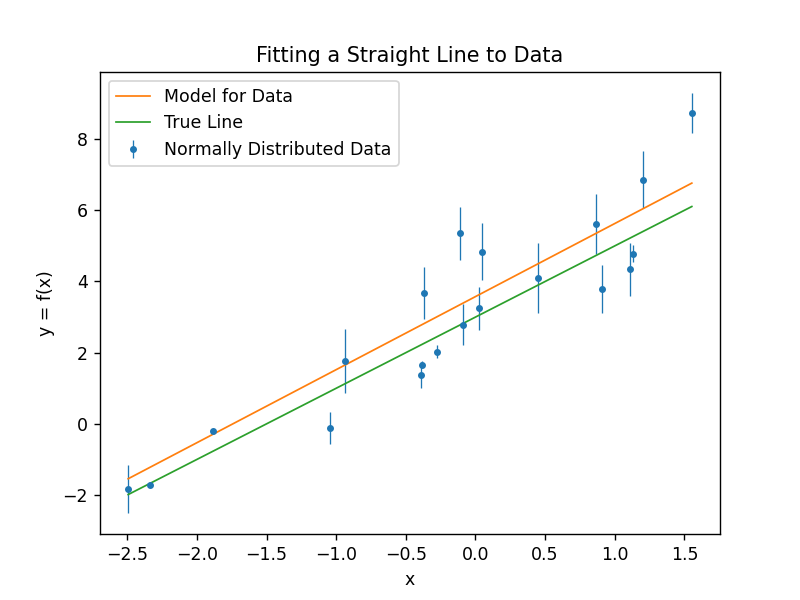

In [9]:
plt.figure()
plt.errorbar(x, y, yerr=yError, fmt='.', label='Normally Distributed Data', elinewidth=0.75)
plt.plot(xOutput, yOutput, label='Model for Data', linewidth=1)
plt.plot(xOutput, yOutput_true, label='True Line', linewidth=1)
plt.title('Fitting a Straight Line to Data')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend()
plt.show()

## Parameter Space

The parameters of an ellipse are defined:

In [10]:
u=Params[0]     #x-position of the center
v=Params[1]    #y-position of the center
a=ParamsError[0]     #radius on the x-axis
b=ParamsError[1]    #radius on the y-axis
t = np.linspace(0, 2*np.pi, 1000)

This allows us to plot the point in parameter space with ellipses that represent the 1st, 2nd and 3rd standard deviations on the parameters.

<IPython.core.display.Javascript object>


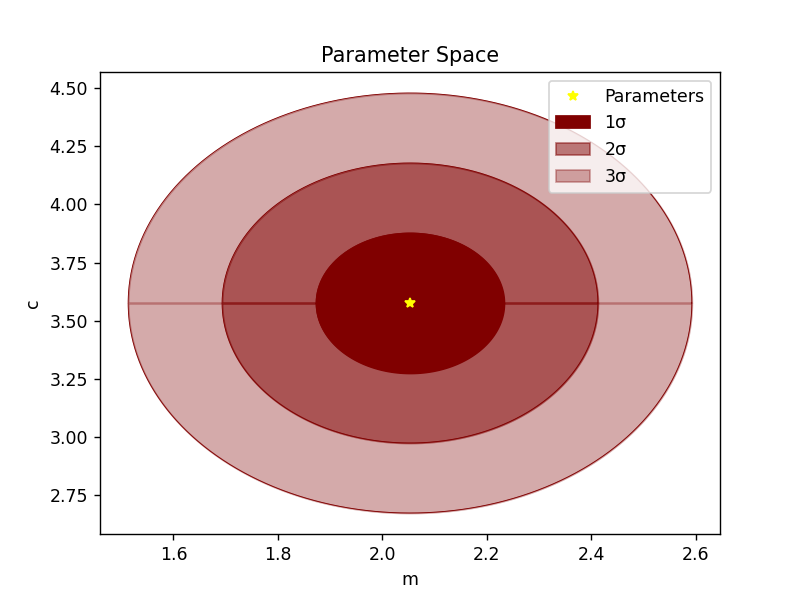

In [16]:
fig, ax = plt.subplots()
plt.plot(u, v, '*', color='yellow', label='Parameters')
for n in range(1, 4):
    χ = u+a*n*np.cos(t)
    υ = v+b*n*np.sin(t)
    plt.plot(χ, υ, color='maroon', linewidth=0.5)
    ax.fill_between(χ, υ, v, alpha=1/n, color='maroon', label=f'{n}σ')

plt.xlabel('m')
plt.ylabel('c')
plt.title('Parameter Space')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


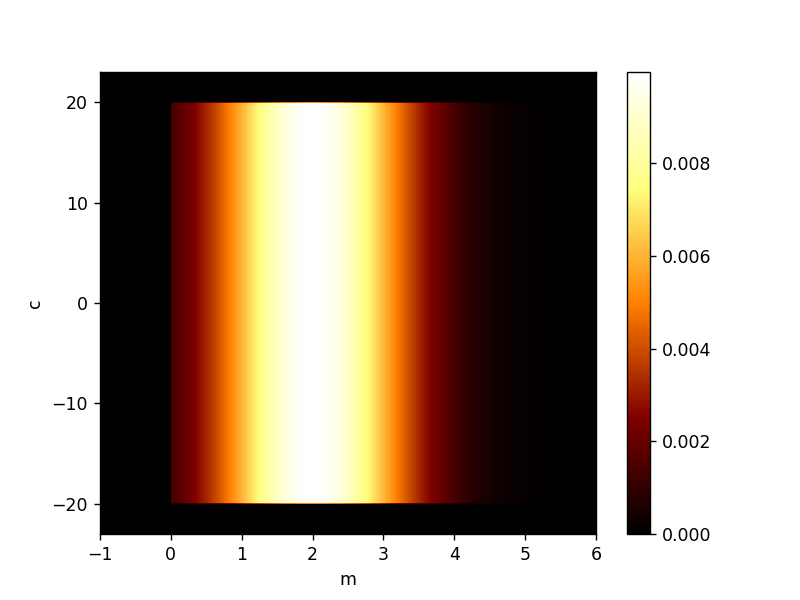

In [47]:
m_space = np.linspace(-1, 6, 1000)
c_space = np.linspace(-23, 23, 1000)
m_prior = Gaussian(m_space, 2, 1)*Unit_range(m_space, xmin=0)
c_prior = Uniform(c_space, -20, 20)
total_prior = np.outer(c_prior, m_prior)

plt.figure()
def heatmap2d(arr, x, y):
    plt.imshow(arr, cmap='afmhot', extent=[x[0], x[-1], y[0], y[-1]], aspect='auto')
    plt.colorbar()
    plt.xlabel('m')
    plt.ylabel('c')
    plt.show()

heatmap2d(total_prior, m_space, c_space)
plt.show()


<IPython.core.display.Javascript object>


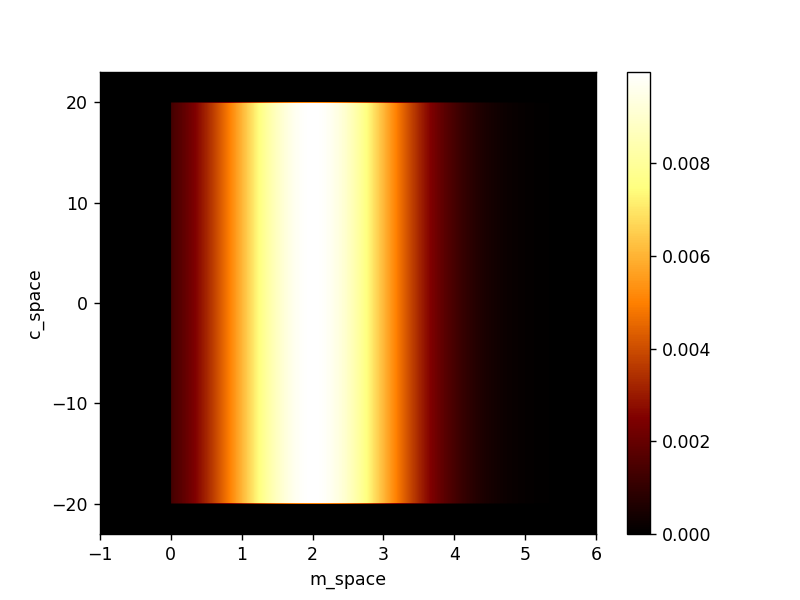

In [43]:
# Generate data
m_space = np.linspace(-1, 6, 1000)
c_space = np.linspace(-23, 23, 1000)
m_prior = Gaussian(m_space, 2, 1) * Unit_range(m_space, xmin=0)
c_prior = Uniform(c_space, -20, 20)
total_prior = np.outer(c_prior, m_prior)

# Plotting
plt.figure()
def heatmap2d(arr, x, y):
    plt.imshow(arr, cmap='afmhot', extent=[x[0], x[-1], y[0], y[-1]], aspect='auto')
    plt.colorbar()
    plt.xlabel('m_space')
    plt.ylabel('c_space')
    plt.show()

heatmap2d(total_prior, m_space, c_space)